<a href="https://colab.research.google.com/github/1Aditya7/WResearch-Statistical-Arbitrage/blob/main/WrightResearchStatArb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

In [39]:
# Defining stock tickers
tickers = ['EICHERMOT.NS', 'M&M.NS']

In [40]:
# Defining time period of 3 years (year to date)
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=3*365)).strftime('%Y-%m-%d')

In [41]:
# Downloading historical stock price data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

data.head(10)

[*********************100%***********************]  2 of 2 completed


Ticker,EICHERMOT.NS,M&M.NS
Date,,
2021-12-20,2338.532227,783.702698
2021-12-21,2348.444336,781.681641
2021-12-22,2416.663330,787.937378
2021-12-23,2410.249268,795.781128
2021-12-24,2369.094238,782.114746
2021-12-27,2370.114746,787.793030
2021-12-28,2410.394775,807.185852
2021-12-29,2489.935059,801.411316
2021-12-30,2484.833252,798.139099


In [42]:
# Checking for missing values
print(data.isnull().sum())

Ticker
EICHERMOT.NS    0
M&M.NS          0
dtype: int64


{insert normalised price formula}

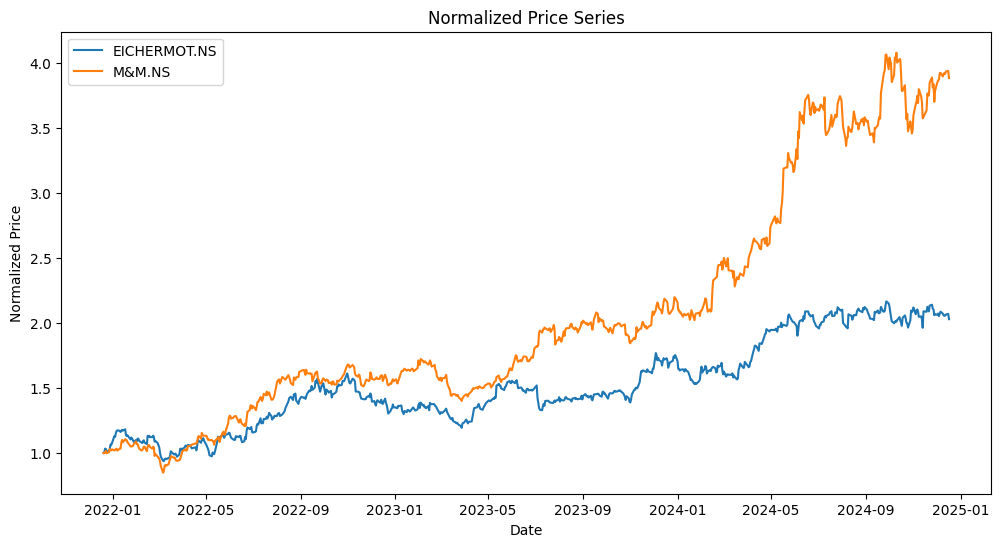

In [43]:
# Normalizing prices (dividing by the first price)
normalized_data = data / data.iloc[0]

# Plotting the normalized price series of the two stocks
plt.figure(figsize=(12, 6))
for stock in normalized_data.columns:
    plt.plot(normalized_data[stock], label=stock)
plt.title('Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [50]:
# Defining time period for correlation and other analysis
period = 60

Correlation Matrix:
 Ticker        EICHERMOT.NS    M&M.NS
Ticker                              
EICHERMOT.NS      1.000000  0.956751
M&M.NS            0.956751  1.000000


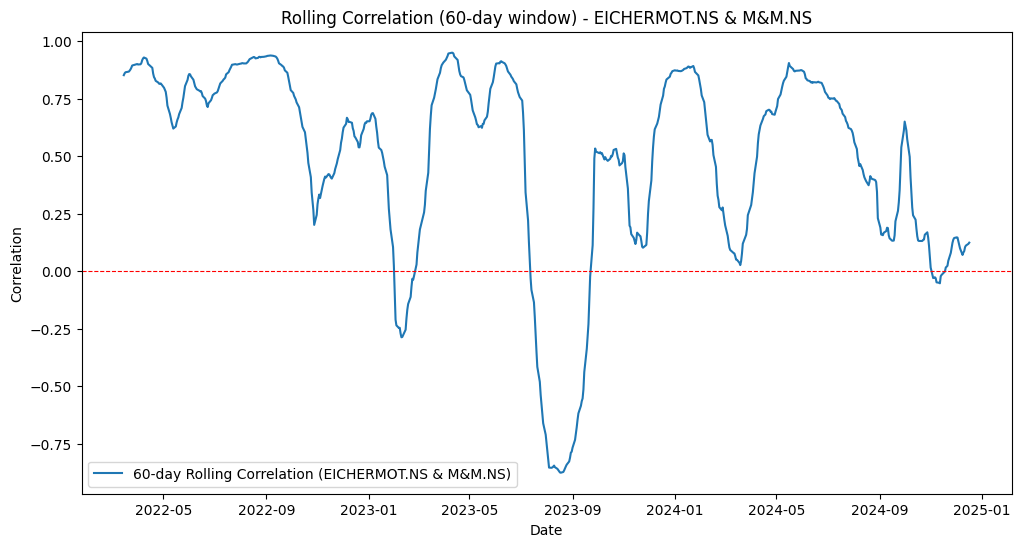

In [49]:
# Correlation over the entire period
correlation = data[tickers].corr()
print("Correlation Matrix:\n", correlation)

# Rolling correlation with a 60-day window
rolling_corr = data[tickers[0]].rolling(window=period).corr(data[tickers[1]])

# Ploting rolling correlation
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr, label=f'{period}-day Rolling Correlation ({tickers[0]} & {tickers[1]})')
plt.axhline(y=0, color='red', linestyle='--', linewidth=0.8)
plt.title(f'Rolling Correlation (60-day window) - {tickers[0]} & {tickers[1]}')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()


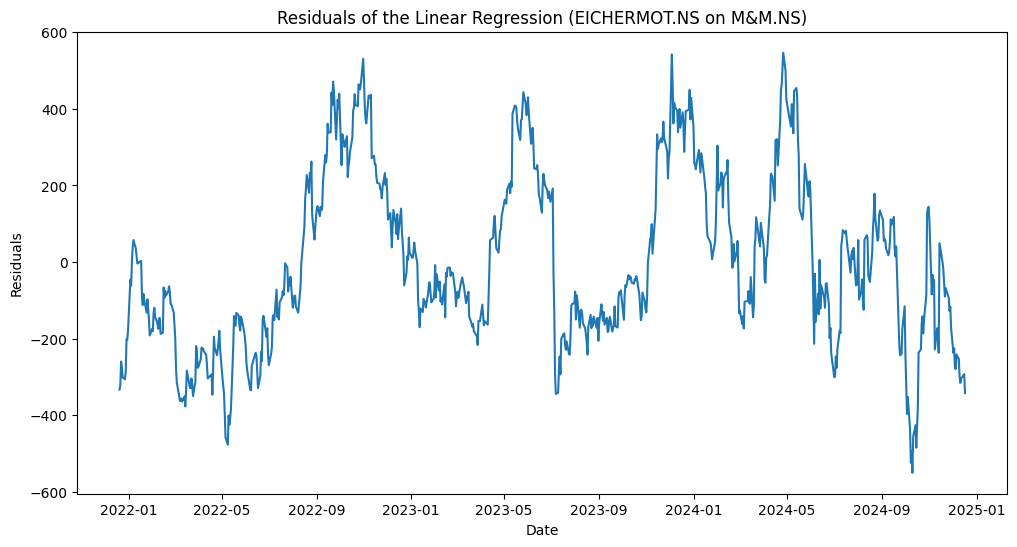

In [45]:
import statsmodels.api as sm

# Performing a linear regression: X price by Y price
X = sm.add_constant(data[tickers[1]])  # Independent variable)
y = data[tickers[0]]  # Dependent variable

model = sm.OLS(y, X).fit()  # Ordinary Least Squares regression
residuals = model.resid  # Residuals (error term)

# Plotting residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title(f'Residuals of the Linear Regression ({tickers[0]} on {tickers[1]})')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

In [46]:
from statsmodels.tsa.stattools import adfuller

# Performing ADF test on the residuals
adf_result = adfuller(residuals)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

# Interpreting the ADF test
if adf_result[1] < 0.05:
    print("\nThe residuals are stationary. The pair is cointegrated.")
else:
    print("\nThe residuals are not stationary. The pair is not cointegrated.")


ADF Statistic: -3.3850658565293172
p-value: 0.011478633788492445
Critical Values: {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}

The residuals are stationary. The pair is cointegrated.


In [51]:
# Calculating the rolling mean and standard deviation of the spread (residuals)
rolling_mean = residuals.rolling(window=period).mean()
rolling_std = residuals.rolling(window=period).std()

In [52]:
# Calculating the Z-Score of the spread
z_score = (residuals - rolling_mean) / rolling_std

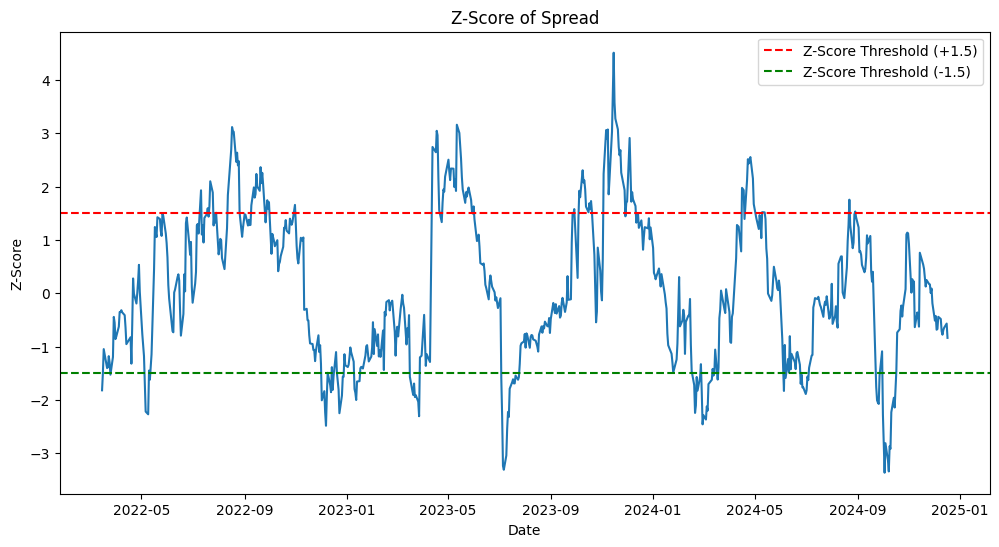

In [72]:
# Plotting the Z-Score
plt.figure(figsize=(12, 6))
plt.plot(z_score)
plt.axhline(1.5, color='r', linestyle='--', label="Z-Score Threshold (+1.5)")
plt.axhline(-1.5, color='g', linestyle='--', label="Z-Score Threshold (-1.5)")
plt.title('Z-Score of Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()


In [54]:
# Generating Trading Signals
long_signal = z_score < -1.5
short_signal = z_score > 1.5
exit_signal = (z_score >= -0.5) & (z_score <= 0.5)

In [71]:
# Displaying the signals
signals = pd.DataFrame(index=z_score.index)
signals['Long'] = long_signal
signals['Short'] = short_signal
signals['Exit'] = exit_signal

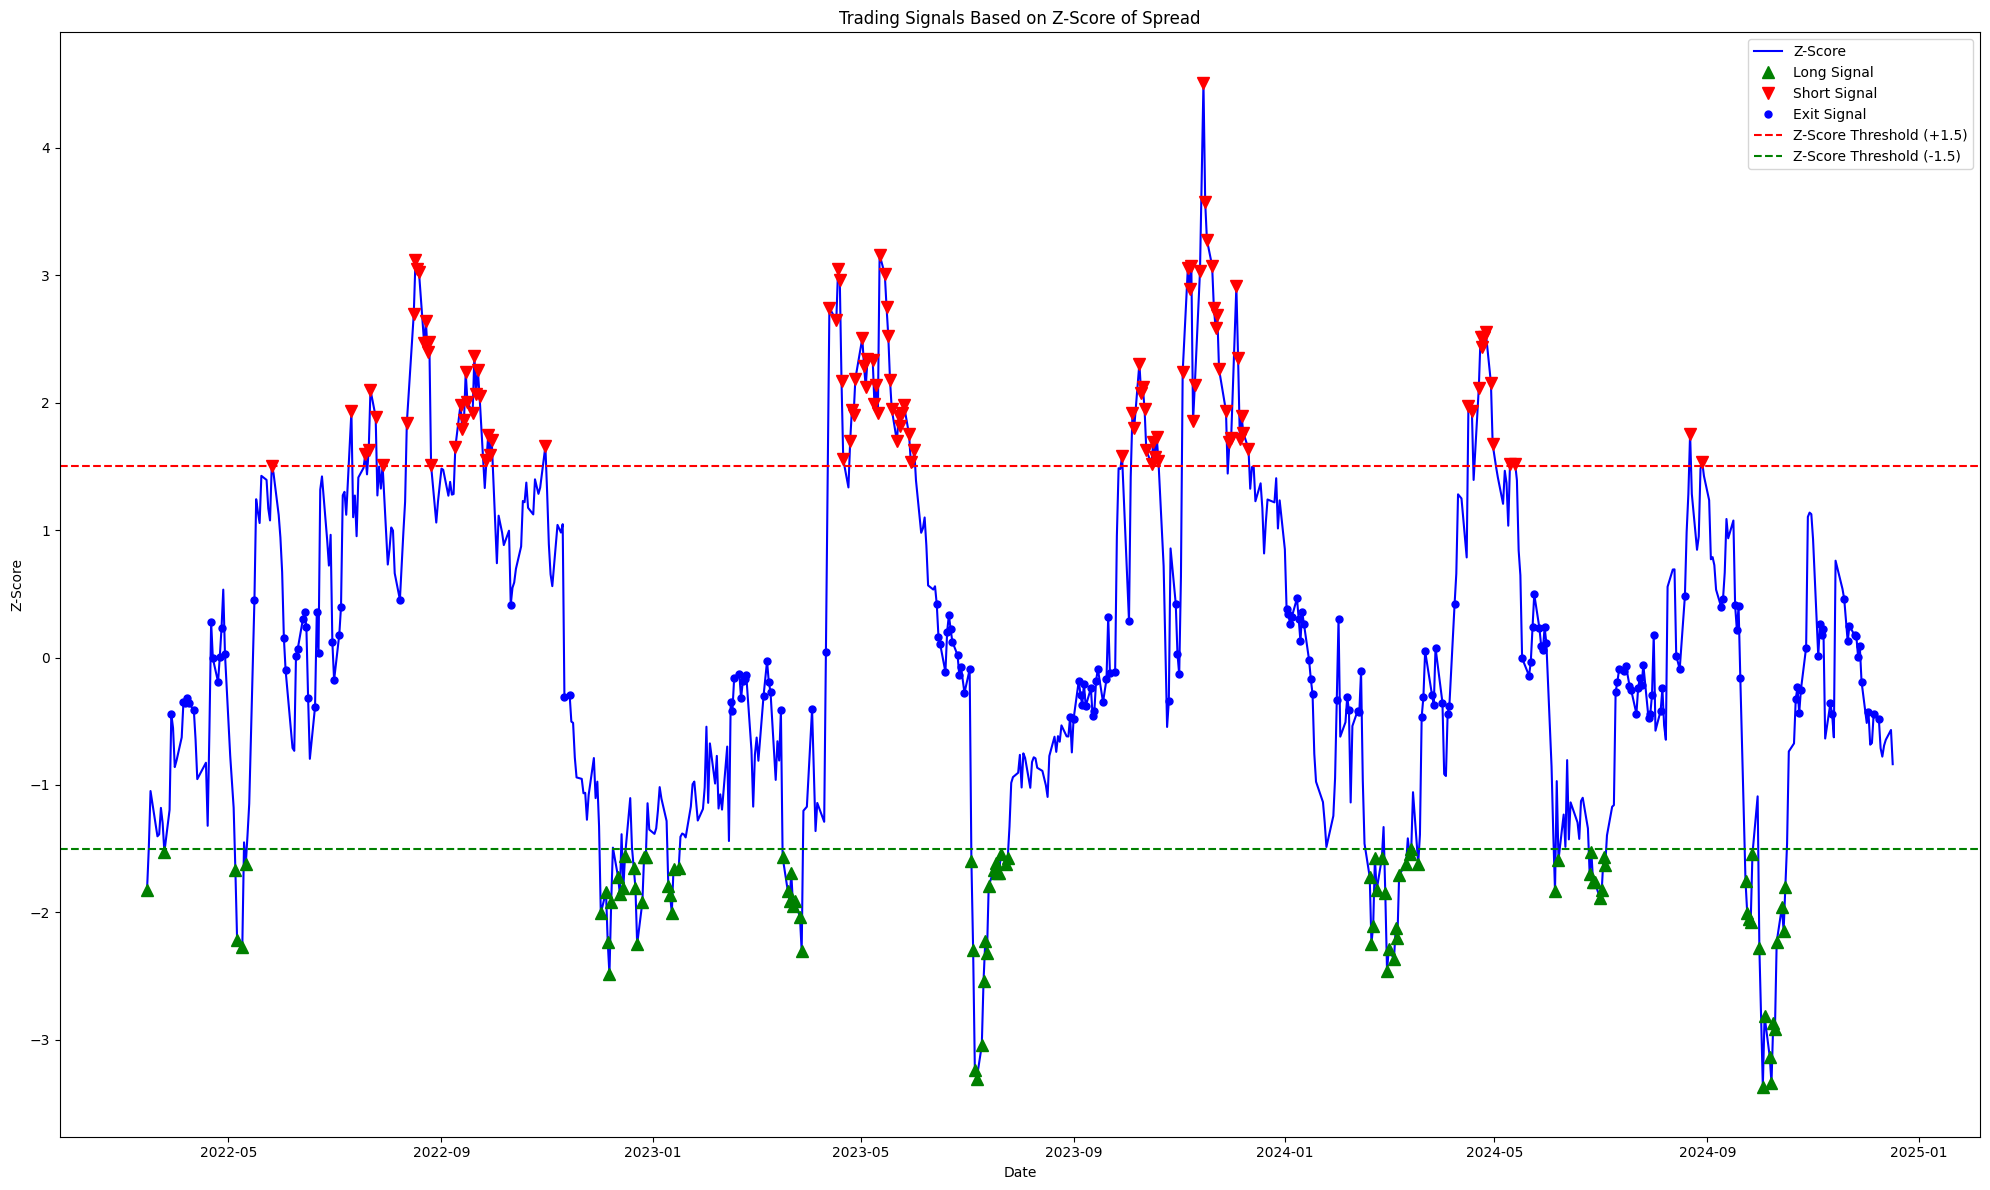

In [70]:
# Visualizing the signals
plt.figure(figsize=(20, 12))

plt.plot(z_score, label='Z-Score', color='b')

plt.plot(z_score[long_signal], 'g^', markersize=8, label='Long Signal')
plt.plot(z_score[short_signal], 'rv', markersize=8, label='Short Signal')
plt.plot(z_score[exit_signal], 'bo', markersize=5, label='Exit Signal')

plt.axhline(1.5, color='r', linestyle='--', label="Z-Score Threshold (+1.5)")
plt.axhline(-1.5, color='g', linestyle='--', label="Z-Score Threshold (-1.5)")

plt.title('Trading Signals Based on Z-Score of Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')

plt.tight_layout()
plt.legend()
plt.show()

In [76]:
# Calculating daily returns for the stock pair
returns_1 = data[tickers[0]].pct_change().dropna()  # Daily returns for Eicher Motors
returns_2 = data[tickers[1]].pct_change().dropna()  # Daily returns for Mahindra & Mahindra

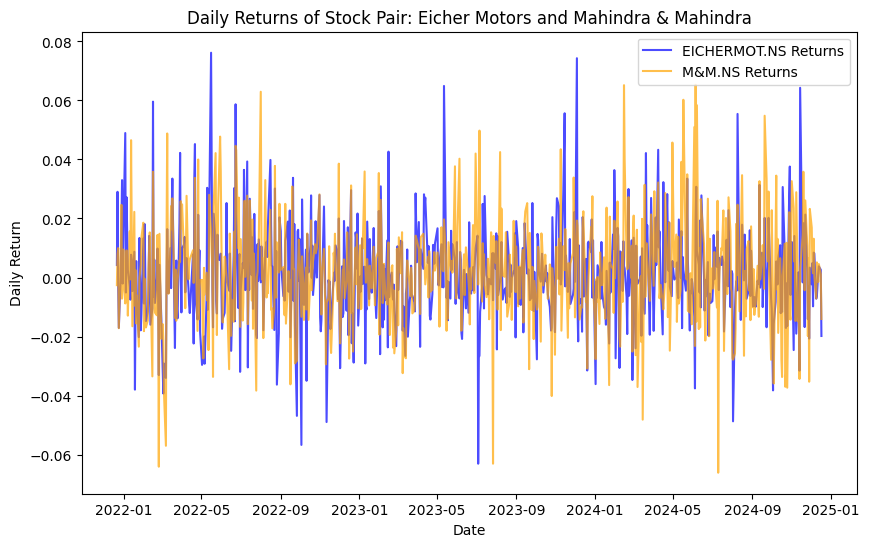

In [124]:
# Plotting the daily returns of both stocks on the same plot
plt.figure(figsize=(10, 6))
plt.plot(returns_1, label=f'{tickers[0]} Returns', color='blue', alpha=0.7)
plt.plot(returns_2, label=f'{tickers[1]} Returns', color='orange', alpha=0.7)

# Adding labels and title
plt.title('Daily Returns of Stock Pair: Eicher Motors and Mahindra & Mahindra')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()

# Display the plot
plt.show()

In [104]:
# Initializing a DataFrame for the strategy
strategy_returns = pd.Series(0, index=data.index)

In [95]:
# Simulating the strategy
capital = 100000  # Assuming an initial capital of INR 100,000
position = 0  # No position at the start

In [106]:
# Iterating over the signals to simulate positions
for i in range(1, len(data)):
    # Debugging: Print the current index and signals
    print(f"Index {i} | Long Signal: {long_signal.iloc[i]} | Short Signal: {short_signal.iloc[i]} | Exit Signal: {exit_signal.iloc[i]} | Position: {position}")

    # Go long when signal is True and no position is held
    if long_signal.iloc[i] and position == 0:
        # Debugging: Entry into a long/short position
        print(f"Going long at index {i}: Buying {tickers[0]} and shorting {tickers[1]}")
        position = capital / data[tickers[0]].iloc[i]  # Calculate position size
        strategy_returns.iloc[i] = position * (returns_1.iloc[i] - returns_2.iloc[i])  # Profit from the long/short position
        print(f"Position: {position}, Strategy Returns: {strategy_returns.iloc[i]}")

    # Go short when signal is True and no position is held
    elif short_signal.iloc[i] and position == 0:
        # Debugging: Entry into a short/long position
        print(f"Going short at index {i}: Shorting {tickers[0]} and buying {tickers[1]}")
        position = capital / data[tickers[0]].iloc[i]  # Calculate position size
        strategy_returns.iloc[i] = position * (returns_2.iloc[i] - returns_1.iloc[i])  # Profit from the short/long position
        print(f"Position: {position}, Strategy Returns: {strategy_returns.iloc[i]}")

    # Exit position when z-score reverts to the mean
    elif exit_signal.iloc[i] and position != 0:
        # Debugging: Exiting the position
        print(f"Exiting position at index {i}")
        strategy_returns.iloc[i] = position * (returns_1.iloc[i] - returns_2.iloc[i])  # Realize profit/loss
        print(f"Strategy Returns at Exit: {strategy_returns.iloc[i]}")
        position = 0  # Reset position

    # Debugging: Check for NaN or invalid values after every iteration
    if pd.isnull(strategy_returns.iloc[i]):
        print(f"NaN detected in strategy_returns at index {i}. Check data or logic.")


Index 1 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 2 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 3 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 4 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 5 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 6 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 7 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 8 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 9 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 10 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 11 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 0
Index 12 | Long Signal: False | Short Signal: False 

<ipython-input-106-e97911affa16>:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2894114975773714' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategy_returns.iloc[i] = position * (returns_1.iloc[i] - returns_2.iloc[i])  # Profit from the long/short position


Index 402 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 403 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 404 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 405 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 406 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 407 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 408 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 409 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 410 | Long Signal: False | Short Signal: False | Exit Signal: False | Position: 30.04996613876496
Index 411 | Long Signal: False | Short Signal: False | Exit Sign

In [117]:
long_signal = long_signal.reindex(data.index, fill_value=False)
short_signal = short_signal.reindex(data.index, fill_value=False)
exit_signal = exit_signal.reindex(data.index, fill_value=False)

In [118]:
nifty_data = yf.download("^NSEI", start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [119]:
benchmark_returns = nifty_data.pct_change().dropna()

In [120]:
# Calculating cumulative returns for the strategy
cumulative_returns = (1 + strategy_returns).cumprod()

# Calculate cumulative returns for the Nifty50 (benchmark)
cumulative_benchmark = (1 + benchmark_returns).cumprod()

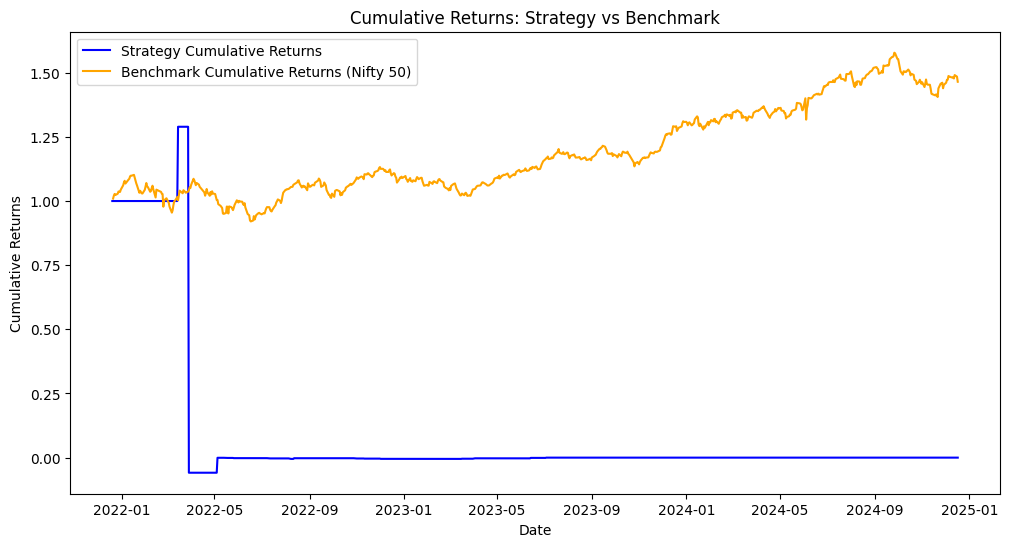

In [121]:
# Plotting Cumulative Returns and P&L
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Strategy Cumulative Returns', color='blue')
plt.plot(cumulative_benchmark, label='Benchmark Cumulative Returns (Nifty 50)', color='orange')
plt.title('Cumulative Returns: Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [122]:
# Calculating P&L
pnl = cumulative_returns - 1

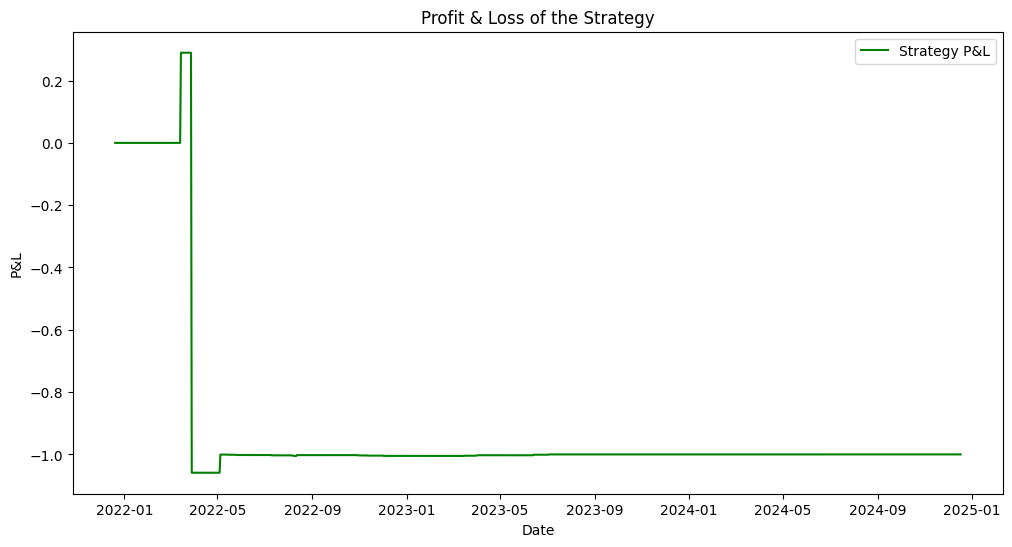

In [123]:
# Plotting the P&L of the Strategy
plt.figure(figsize=(12, 6))
plt.plot(pnl, label='Strategy P&L', color='green')
plt.title('Profit & Loss of the Strategy')
plt.xlabel('Date')
plt.ylabel('P&L')
plt.legend()
plt.show()

In [114]:
# Display the final P&L and cumulative returns
print(f"Final Strategy P&L: {pnl[-1]:.2f}")
print(f"Final Cumulative Return of the Strategy: {cumulative_returns[-1]:.2f}")
print(f"Final Cumulative Return of Benchmark: {cumulative_benchmark[-1]:.2f}")

Final Strategy P&L: -1.00
Final Cumulative Return of the Strategy: 0.00


<ipython-input-114-680c9bcbb35e>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Final Strategy P&L: {pnl[-1]:.2f}")
<ipython-input-114-680c9bcbb35e>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Final Cumulative Return of the Strategy: {cumulative_returns[-1]:.2f}")


KeyError: -1